In [1]:
#%pip install
#!pip3 install matplotlib
#!pip3 install scipy
#!pip3 instalsklearn
#!pip3 install joblib --upgrade
#!pip3 install fsspec
#!pip3 install s3fs 
#!pip3 install jmespath --upgrade
#!python3 -m jmespath install
#!pip3 install jmespath==0.9.4
#!conda install -c conda-forge jmespath

In [2]:
import s3fs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kurtosis
from sklearn.covariance import LedoitWolf
import os

In [3]:
df_revisado=pd.read_csv('s3://proyecto-integrador/trusted/IBR_Input_Data.csv', header=0)
df_revisado=df_revisado.drop([0])
df_revisado.iloc[:,0]=pd.to_datetime(df_revisado.iloc[:,0])
df_revisado.set_index('Fecha', inplace=True)

In [4]:
df_revisado.shape

(1666, 139)

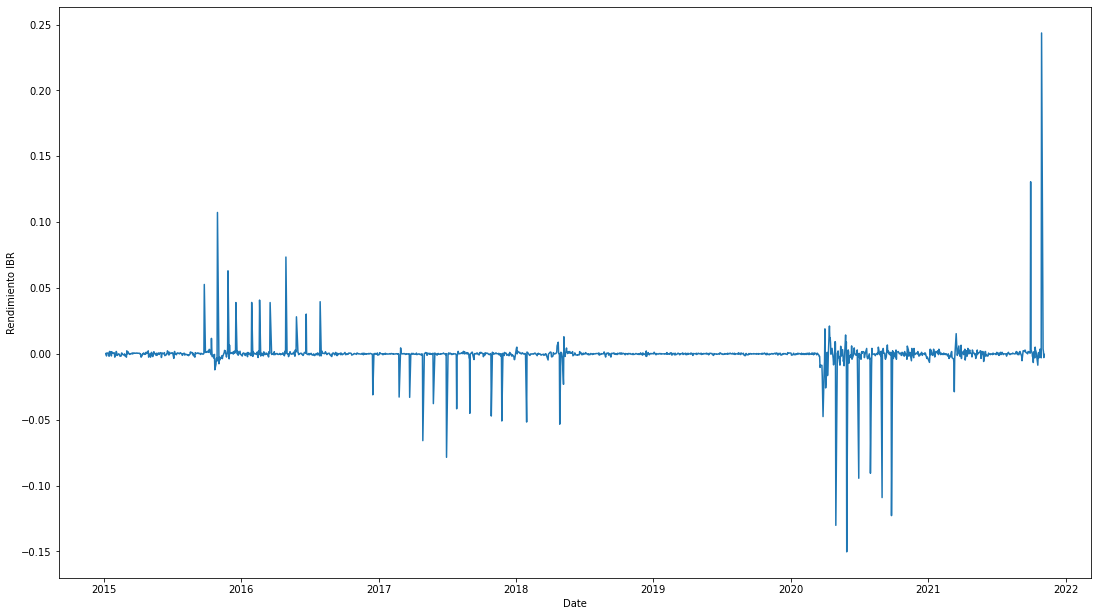

In [5]:
from matplotlib.pyplot import figure
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(df_revisado.loc[:,'Indicador Bancario de Referencia (IBR) overnight nominal'])
plt.rcParams.update({'font.size': 22})
plt.xlabel("Date")
plt.ylabel("Rendimiento IBR")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

Revisando el comportamiento de los rendimientos o variaciones diarias del IBR, es posible concluir que posee un comportamiento estable la mayor parte del tiempo, sin embargo, tiende a presentar picos de subida y bajada. Con el modelado, se busca identificar dichos picos.

In [6]:
X=df_revisado.drop('Indicador Bancario de Referencia (IBR) overnight nominal',axis=1)
Y=df_revisado.loc[:,'Indicador Bancario de Referencia (IBR) overnight nominal']

Revisamos las correlaciones lineales entre las variables X y eliminamos del estudio las variables con correlaciones lineales mayores a 40%, por considerarse redundantes

In [7]:
df_revisada = df_revisado
X_revisada = X
Corr_X = np.corrcoef(np.transpose(X))
np.fill_diagonal(Corr_X, 0)
while np.max(abs(Corr_X))>0.4:
    posicion = np.where(abs(Corr_X)==np.max(abs(Corr_X)))[0]
    df_revisada =  df_revisada.drop(X_revisada.columns[posicion[0]],axis=1)   
    X_revisada = X_revisada.drop(X_revisada.columns[posicion[0]],axis=1)
    Corr_X = np.corrcoef(np.transpose(X_revisada))
    np.fill_diagonal(Corr_X, 0)

Máxima Correlación tras limpieza de Variables redundantes.

In [8]:
np.max(Corr_X).round(2)

0.4

In [9]:
df_revisada.shape

(1666, 32)

Listado de Variables de entrada con correlaciones lineales menores a 40% entre ellas.

In [10]:
X_revisada.columns 

Index(['Tasa Representativa del Mercado (TRM)',
       'Indicador Bancario de Referencia (IBR) a 3 meses efectiva',
       'Operaciones interbancarias - Monto',
       'Tasa de interés Cero Cupón Títulos de Tesorería (TES) pesos - 10 años',
       'Tasa de interés Cero Cupón Títulos de Tesorería (TES) UVR - 1 año',
       'Inflación total anual',
       'Inflación sin alimentos primarios servicios públicos y combustibles',
       'Inflación Bienes y servicios diversos',
       'Índice de precios al consumidor: Bogotá D.C.',
       'Índice de Precios del Productor (IPP)',
       'Depósitos en el sistema financiero bonos mensual_x',
       'Remesas de trabajadores mensual_x',
       'Tasa de Depósitos a Término Fijo (DTF) a 90 días semanal_y',
       'Tasa de Certificado de Depósito a Término (CDT) a 90 días diaria_y',
       'Tasa de Certificado de Depósito a Término (CDT) a 180 días semanal_y',
       'Tasa de Certificado de Depósito a Término (CDT) a 180 días diaria_y',
       'Tasa d

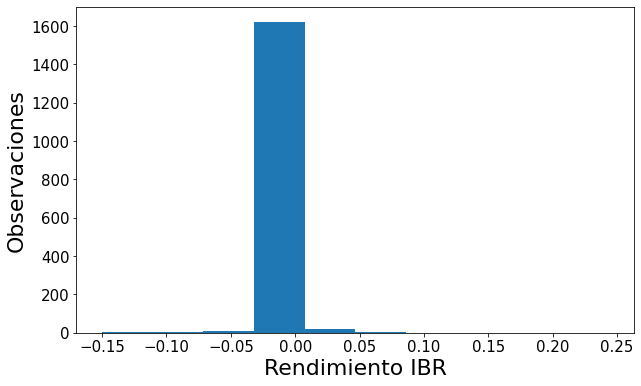

In [11]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.hist(Y)
plt.rcParams.update({'font.size': 22})
plt.xlabel("Rendimiento IBR")
plt.ylabel("Observaciones")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

Se observa que hay datos muy extremos que podrían generar sesgos en los resultados del modelo. Se procede a eliminar outlayers.

Para identificar Outlayers usaremos el método de proyección de todos los datos sobre la dimensión de máxima Curtosis.

In [12]:
Num_Va = df_revisada.shape[1]
MatrizVectores=np.random.rand(Num_Va,1000)
Vector_normalizado = np.empty((Num_Va,1000))
for i in range(len(MatrizVectores[1,:])):
    Vector_normalizado[:,i]=MatrizVectores[:,i]/np.linalg.norm(MatrizVectores[:,i])
Vector_normalizado.shape

(32, 1000)

In [13]:
Proyeccion=np.dot(np.array(df_revisada),Vector_normalizado)
Proyeccion.shape

(1666, 1000)

In [14]:
Kur=kurtosis(Proyeccion,axis=0)
np.where(Kur==max(Kur))

(array([604]),)

In [15]:
ProyeccionSeleccionada=Proyeccion[:,np.where(Kur==max(Kur))[0]]
ProyeccionSeleccionada.shape

(1666, 1)

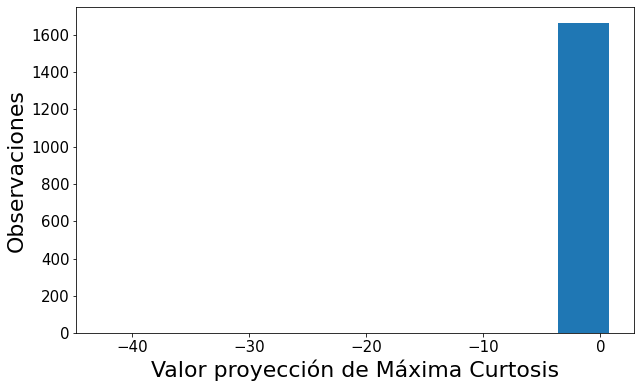

In [16]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.hist(ProyeccionSeleccionada)
plt.rcParams.update({'font.size': 22})
plt.xlabel("Valor proyección de Máxima Curtosis")
plt.ylabel("Observaciones")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

Al representar la data proyectada en la dimensión de máxima curtosis, se observa que hay outlayer extremos que generan un sesgo considerable sobre el connjunto total de datos.

In [17]:
np.percentile(ProyeccionSeleccionada,5),np.percentile(ProyeccionSeleccionada,95)

(-0.05850223857010564, 0.06990415946386616)

Eliminamos los elmentos que se encuentren 5% por debajo y 5% por encima del conjunto de datos en la proyección de máxima curtosis.

In [18]:
VectorLogico=np.logical_and(ProyeccionSeleccionada>np.percentile(ProyeccionSeleccionada,5),ProyeccionSeleccionada<np.percentile(ProyeccionSeleccionada,95))

In [19]:
ProyeccionFinal=(ProyeccionSeleccionada[np.where(VectorLogico==True)[0]])

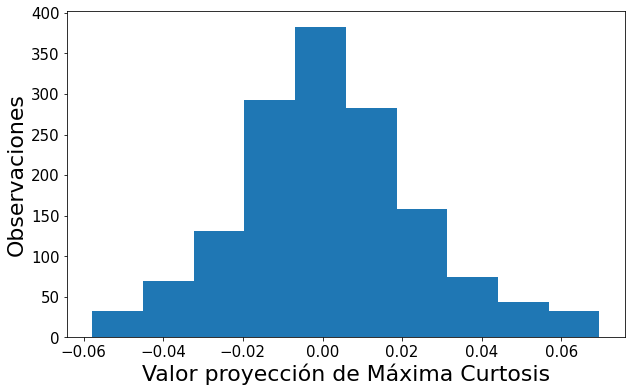

In [20]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.hist(ProyeccionFinal)
plt.rcParams.update({'font.size': 22})
plt.xlabel("Valor proyección de Máxima Curtosis")
plt.ylabel("Observaciones")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

El nuevo historgrama con los sin los outlayers tiene una comportmiento mucho más normal, con un mayor número de observaciones para valores cercanos a la media.

In [21]:
dfFinal=(df_revisada.iloc[np.where(VectorLogico==True)[0]])

In [22]:
XFinal=dfFinal.drop('Indicador Bancario de Referencia (IBR) overnight nominal',axis=1)
YFinal=dfFinal.loc[:,'Indicador Bancario de Referencia (IBR) overnight nominal']

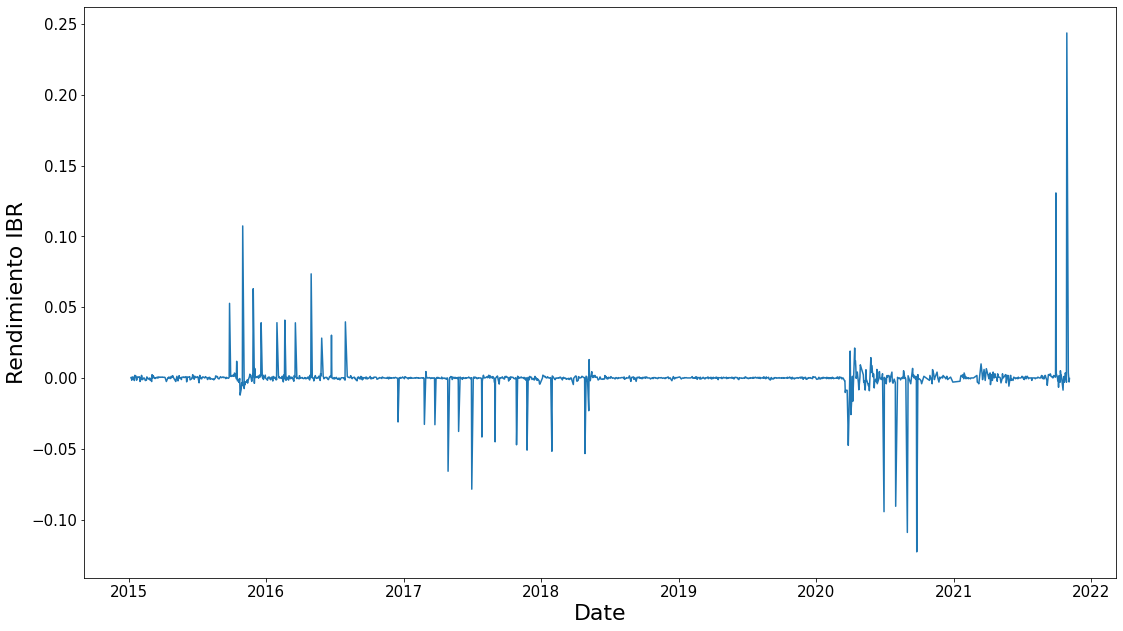

In [23]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(dfFinal.loc[:,'Indicador Bancario de Referencia (IBR) overnight nominal'])
plt.rcParams.update({'font.size': 22})
plt.xlabel("Date")
plt.ylabel("Rendimiento IBR")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

Aún habiendo eliminado los datos extremos es posible observar los picos de subida y bajada en el rendimeinto del IBR.

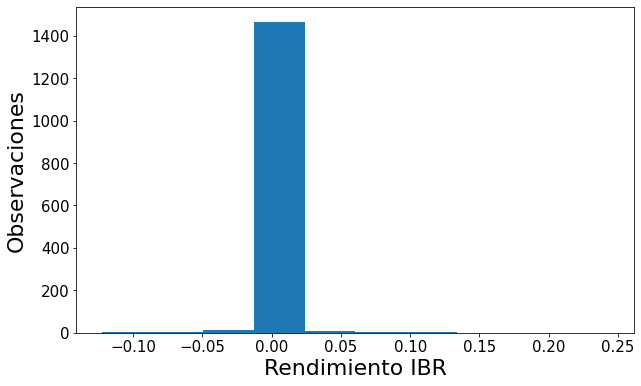

In [24]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.hist(YFinal)
plt.rcParams.update({'font.size': 22})
plt.xlabel("Rendimiento IBR")
plt.ylabel("Observaciones")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

In [25]:
dfFinal.shape

(1498, 32)

In [26]:
dfFinal.to_csv('s3://proyecto-integrador/trusted/Data_tras_Analisis Exploratorio.csv')